# Species distribution modeling with climate data

## 1. Setup

### 1.1 Install dependencies

In [1]:
!pip install -U -q torch==2.5.0 torchvision matplotlib tqdm gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 133.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install scikit-multilearn
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.3 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, label_ranking_loss, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

### 1.2 Check if cuda available

In [4]:
print(torch.cuda.is_available())

True


## 2. Data loading

### 2.1 Mounting drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.1 Downloading data

In [ ]:
base_path = "/content/drive/MyDrive/IPEO_Species_Distribution_Modeling/"

os.chdir(base_path)
os.getcwd()

'/content/drive/MyDrive/IPEO/Project'

In [7]:
env_train = pd.read_csv("data/env_variables_training.csv")
env_test  = pd.read_csv("data/env_variables_test.csv")

species_train = np.load("data/species_data_training.npy")
species_test  = np.load("data/species_data_test.npy")

print("Training shapes:")
print("Env:", env_train.shape)
print("Labels:", species_train.shape)


Training shapes:
Env: (5000, 22)
Labels: (5000, 342)


### 2.2 Reshaping and removing columns

In [8]:
# Extract coordinates
train_lons = env_train.iloc[:, 1]
train_lats = env_train.iloc[:, 2]

test_lons = env_test.iloc[:, 1]
test_lats = env_test.iloc[:, 2]

env_train = env_train.values.astype(np.float32)
env_test  = env_test.values.astype(np.float32)

env_train = env_train[:, 3:]
env_test  = env_test[:, 3:]

# Normalization
mean_env = env_train.mean(axis=0)
std_env = env_train.std(axis=0)
env_train = (env_train - mean_env) / std_env
env_test = (env_test - mean_env) / std_env

species_train = species_train.astype(np.float32)
species_test  = species_test.astype(np.float32)

print("Env train shape after removing first 3 columns:", env_train.shape)
print("Env test shape after removing first 3 columns:", env_test.shape)

Env train shape after removing first 3 columns: (5000, 19)
Env test shape after removing first 3 columns: (1000, 19)


### 2.3 Defining dataset class

In [9]:
class GeoPlantDataset(Dataset):
    def __init__(self, tabular, labels, split='train', val_split=0.2, random_state=42):
        """
        Args:
            tabular: numpy array of climate data
            labels: numpy array of species labels
            split: 'train', 'val', 'test', or None
            val_split: fraction of training data to use for validation (ignored if split is None)
            random_state: random seed for reproducibility
        """
        self.split = split

        if split == 'test' or split is None:
            self.tabular = tabular
            self.labels = labels

        else:
            indices = np.arange(len(labels))

            if val_split <= 0:
                self.tabular = tabular
                self.labels = labels
            else:
                train_idx, val_idx = train_test_split(
                    indices,
                    test_size=val_split,
                    random_state=random_state
                )

                if split == 'train':
                    self.tabular = tabular[train_idx]
                    self.labels = labels[train_idx]
                elif split == 'val':
                    self.tabular = tabular[val_idx]
                    self.labels = labels[val_idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tab = torch.from_numpy(self.tabular[idx]).float()
        y   = torch.from_numpy(self.labels[idx]).float()
        return tab, y

### 2.4 Creating dataset

In [10]:
# Create datasets with train/val split
train_dataset = GeoPlantDataset(
    tabular=env_train,
    labels=species_train,
    split='train',
    val_split=0.2
)

val_dataset = GeoPlantDataset(
    tabular=env_train,
    labels=species_train,
    split='val',
    val_split=0.2
)

test_dataset = GeoPlantDataset(
    tabular=env_test,
    labels=species_test,
    split='test'
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4000
Val samples: 1000
Test samples: 1000


### 2.5 Checking dimensions

In [11]:
tab, y = train_dataset[0]

print("Tabular:", tab.shape)
print("Label:", y.shape)

Tabular: torch.Size([19])
Label: torch.Size([342])


## 3. Satellite imagery species distribution model

In [12]:
class TabularEncoder(nn.Module):
    def __init__(self, in_features=19, out_features=342):
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(in_features, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Dropout(0.1),

          nn.Linear(64, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(0.2),

          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(0.3),

          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(),

          nn.Linear(512, out_features)
        )

    def forward(self, x):
        return self.net(x)

model = TabularEncoder(in_features=19, out_features=342)
print("Climate model with parameters:", sum(p.numel() for p in model.parameters()))


Climate model with parameters: 351574


## 4. Training the model

### 4.1 Training one epoch

In [13]:
def train_epoch(model, loader, optimizer, criterion, device='cpu'):
    model.train()
    running_loss = 0.0
    samples_processed = 0

    for tab, y in loader:
        tab = tab.to(device).float()
        y = y.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        logits = model(tab)
        loss = criterion(logits, y)

        # Backward pass
        loss.backward()

        # Gradient Clipping (Focal loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Accurate accumulation
        batch_size = tab.size(0)
        running_loss += loss.item() * batch_size
        samples_processed += batch_size

    return running_loss / samples_processed

### 4.2 Evaluation of the model

In [14]:
def evaluate(model, loader, criterion, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    samples_processed = 0

    with torch.no_grad():
        for tab, y in loader:
            tab = tab.to(device).float()
            y = y.to(device).float()

            logits = model(tab)
            loss = criterion(logits, y)

            running_loss += loss.item() * tab.size(0)
            samples_processed += tab.size(0)

            # Probabilities for ranking metrics
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Robust AUC Calculation
    try:
        macro_auc = roc_auc_score(all_labels, all_preds, average='macro')
    except ValueError:
        # Fallback if some classes have no positives in this fold
        macro_auc = 0.0
        print("Warning: Some classes had no positive samples in this fold.")

    # Average Precision
    macro_avg_prec = average_precision_score(all_labels, all_preds, average='macro')

    avg_loss = running_loss / samples_processed

    return macro_auc, macro_avg_prec, avg_loss

### 4.3 Calculate species weights (for param alpha in focal loss function)

In [15]:
counts = species_train.sum(axis=0)
total_samples = len(species_train)

weights = total_samples / (counts + 1e-5)

weights = weights / weights.mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
species_weights = torch.tensor(weights, dtype=torch.float).to(device)

### 4.4 Focal loss function

In [16]:
class MultiLabelFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(MultiLabelFocalLoss, self).__init__()
        self.gamma = gamma

        # Parameter alpha can be a float or a tensor of shape (num_classes,)
        self.alpha = alpha

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        # Compute p_t (probability of ground truth)
        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)

        # Modulating factor (Focal component)
        focal_weight = (1 - p_t) ** self.gamma

        # Corrected Alpha Balancing for Multi-Label
        if isinstance(self.alpha, torch.Tensor):
            alpha_pos = self.alpha
            alpha_neg = 1 - 0.25 # Keep negative weight constant and small
            alpha_weight = targets * alpha_pos + (1 - targets) * alpha_neg
        else:
            # Standard scalar behavior
            alpha_weight = targets * self.alpha + (1 - targets) * (1 - self.alpha)

        loss = alpha_weight * focal_weight * bce_loss

        return loss.mean()

### 4.5 K-fold cross validation


--- Starting Fold 1/5 ---
  --> Epoch 1: Best AUC Updated: 0.7531
Epoch 1 Train_loss: 0.0298 | Val_Loss: 0.0238 | Val_AUC: 0.7531| Val_avg_prec: 0.1353
  --> Epoch 2: Best AUC Updated: 0.7668
Epoch 2 Train_loss: 0.0246 | Val_Loss: 0.0233 | Val_AUC: 0.7668| Val_avg_prec: 0.1466
  --> Epoch 3: Best AUC Updated: 0.7749
Epoch 3 Train_loss: 0.0240 | Val_Loss: 0.0230 | Val_AUC: 0.7749| Val_avg_prec: 0.1546
  --> Epoch 4: Best AUC Updated: 0.7758
Epoch 4 Train_loss: 0.0238 | Val_Loss: 0.0231 | Val_AUC: 0.7758| Val_avg_prec: 0.1554
  --> Epoch 5: Best AUC Updated: 0.7866
Epoch 5 Train_loss: 0.0234 | Val_Loss: 0.0228 | Val_AUC: 0.7866| Val_avg_prec: 0.1606
  --> Epoch 6: Best AUC Updated: 0.7901
Epoch 6 Train_loss: 0.0233 | Val_Loss: 0.0225 | Val_AUC: 0.7901| Val_avg_prec: 0.1652
Epoch 7 Train_loss: 0.0231 | Val_Loss: 0.0225 | Val_AUC: 0.7897| Val_avg_prec: 0.1635
  --> Epoch 8: Best AUC Updated: 0.7906
Epoch 8 Train_loss: 0.0229 | Val_Loss: 0.0224 | Val_AUC: 0.7906| Val_avg_prec: 0.1683
  -->

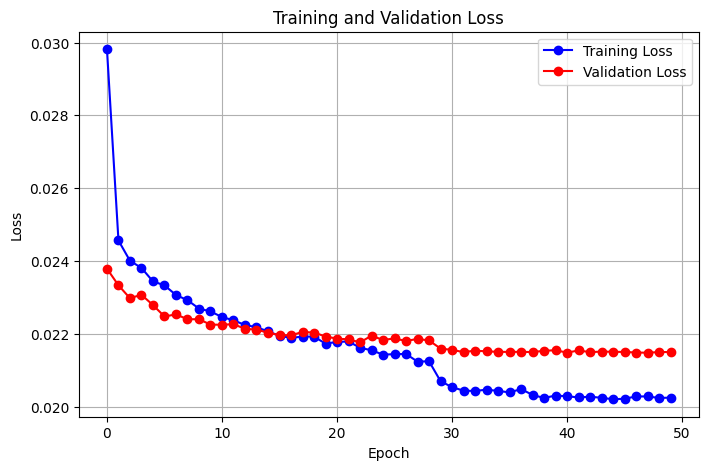

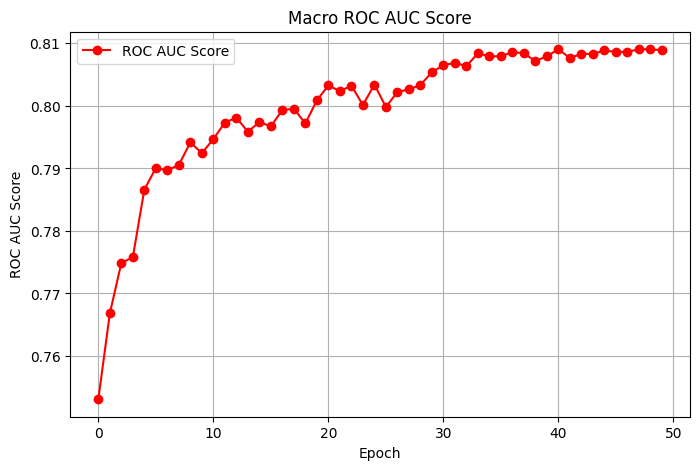

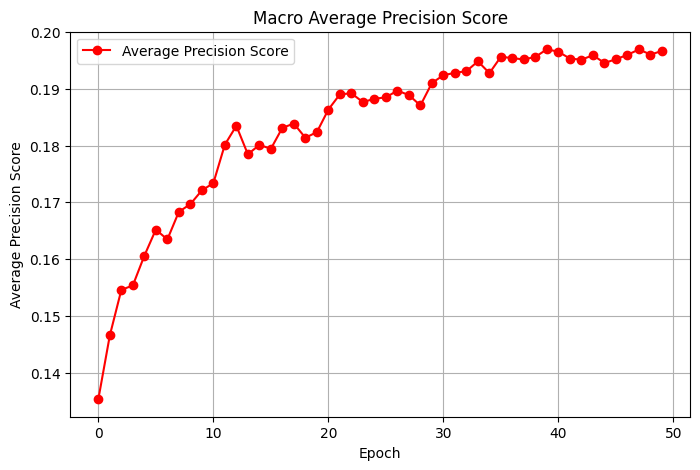


--- Starting Fold 2/5 ---
  --> Epoch 1: Best AUC Updated: 0.7461
Epoch 1 Train_loss: 0.0300 | Val_Loss: 0.0241 | Val_AUC: 0.7461| Val_avg_prec: 0.1243
  --> Epoch 2: Best AUC Updated: 0.7655
Epoch 2 Train_loss: 0.0246 | Val_Loss: 0.0232 | Val_AUC: 0.7655| Val_avg_prec: 0.1417
  --> Epoch 3: Best AUC Updated: 0.7712
Epoch 3 Train_loss: 0.0239 | Val_Loss: 0.0232 | Val_AUC: 0.7712| Val_avg_prec: 0.1456
  --> Epoch 4: Best AUC Updated: 0.7749
Epoch 4 Train_loss: 0.0237 | Val_Loss: 0.0231 | Val_AUC: 0.7749| Val_avg_prec: 0.1538
  --> Epoch 5: Best AUC Updated: 0.7802
Epoch 5 Train_loss: 0.0236 | Val_Loss: 0.0227 | Val_AUC: 0.7802| Val_avg_prec: 0.1603
Epoch 6 Train_loss: 0.0233 | Val_Loss: 0.0227 | Val_AUC: 0.7781| Val_avg_prec: 0.1595
  --> Epoch 7: Best AUC Updated: 0.7838
Epoch 7 Train_loss: 0.0232 | Val_Loss: 0.0227 | Val_AUC: 0.7838| Val_avg_prec: 0.1636
  --> Epoch 8: Best AUC Updated: 0.7875
Epoch 8 Train_loss: 0.0229 | Val_Loss: 0.0225 | Val_AUC: 0.7875| Val_avg_prec: 0.1653
  -->

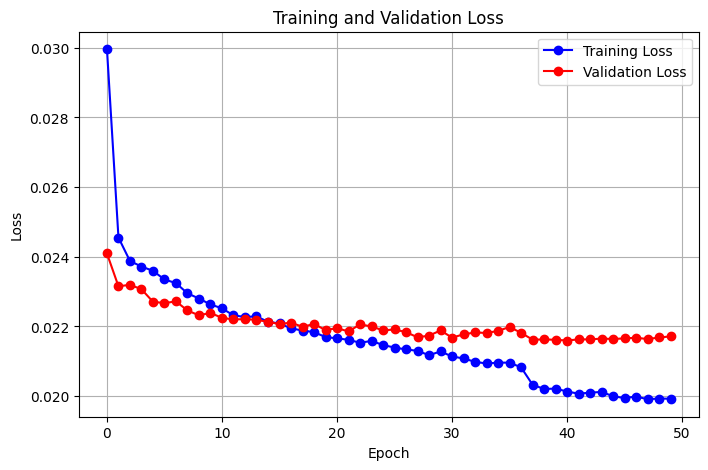

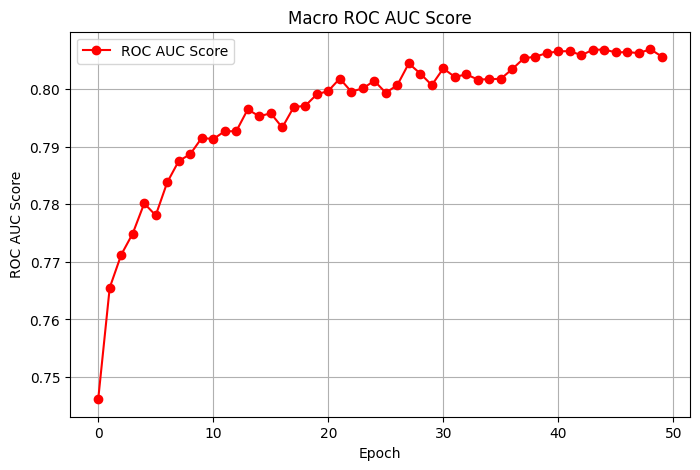

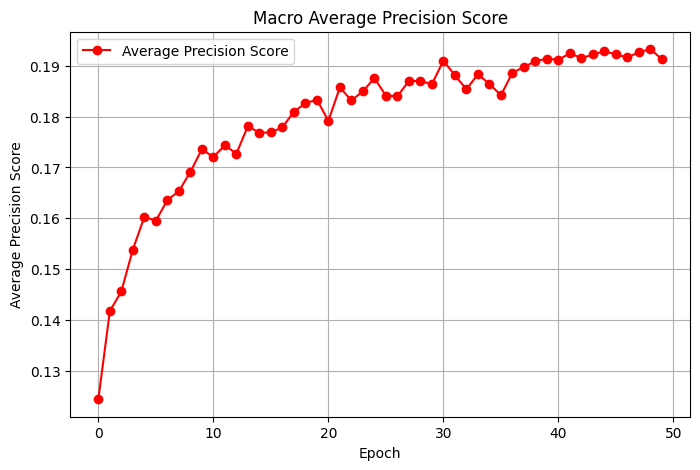


--- Starting Fold 3/5 ---
  --> Epoch 1: Best AUC Updated: 0.7434
Epoch 1 Train_loss: 0.0299 | Val_Loss: 0.0244 | Val_AUC: 0.7434| Val_avg_prec: 0.1223
  --> Epoch 2: Best AUC Updated: 0.7707
Epoch 2 Train_loss: 0.0244 | Val_Loss: 0.0238 | Val_AUC: 0.7707| Val_avg_prec: 0.1396
  --> Epoch 3: Best AUC Updated: 0.7765
Epoch 3 Train_loss: 0.0239 | Val_Loss: 0.0234 | Val_AUC: 0.7765| Val_avg_prec: 0.1419
  --> Epoch 4: Best AUC Updated: 0.7860
Epoch 4 Train_loss: 0.0236 | Val_Loss: 0.0230 | Val_AUC: 0.7860| Val_avg_prec: 0.1541
Epoch 5 Train_loss: 0.0235 | Val_Loss: 0.0232 | Val_AUC: 0.7854| Val_avg_prec: 0.1609
  --> Epoch 6: Best AUC Updated: 0.7912
Epoch 6 Train_loss: 0.0231 | Val_Loss: 0.0228 | Val_AUC: 0.7912| Val_avg_prec: 0.1636
  --> Epoch 7: Best AUC Updated: 0.7928
Epoch 7 Train_loss: 0.0230 | Val_Loss: 0.0227 | Val_AUC: 0.7928| Val_avg_prec: 0.1668
  --> Epoch 8: Best AUC Updated: 0.7966
Epoch 8 Train_loss: 0.0230 | Val_Loss: 0.0227 | Val_AUC: 0.7966| Val_avg_prec: 0.1752
Epoch

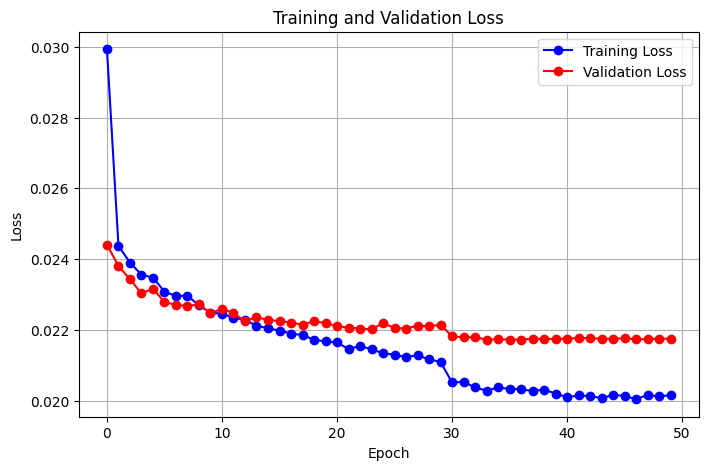

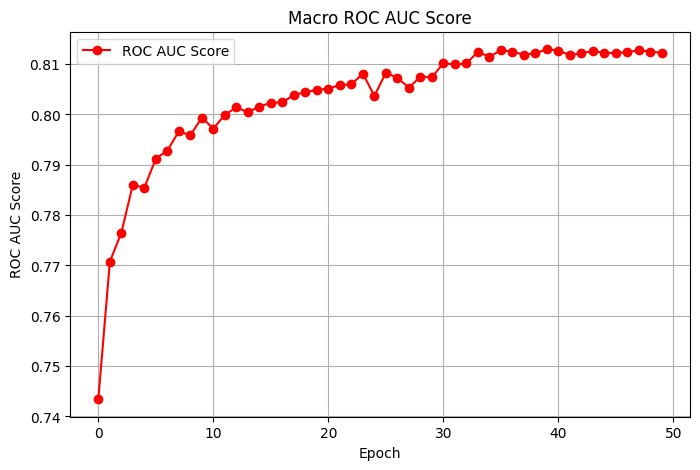

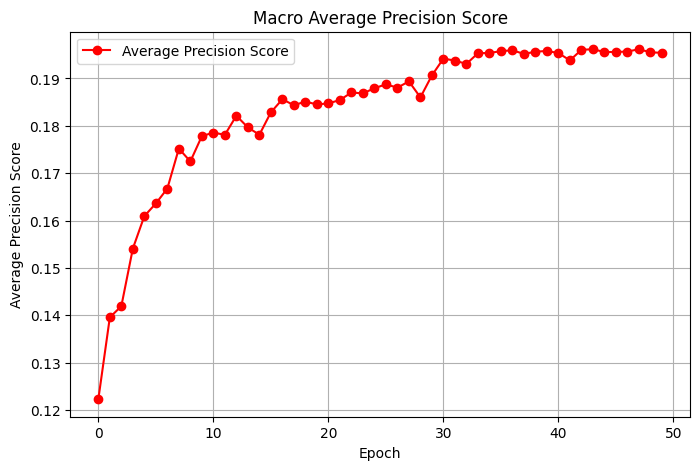


--- Starting Fold 4/5 ---
  --> Epoch 1: Best AUC Updated: 0.7482
Epoch 1 Train_loss: 0.0298 | Val_Loss: 0.0240 | Val_AUC: 0.7482| Val_avg_prec: 0.1303
  --> Epoch 2: Best AUC Updated: 0.7673
Epoch 2 Train_loss: 0.0245 | Val_Loss: 0.0235 | Val_AUC: 0.7673| Val_avg_prec: 0.1438
  --> Epoch 3: Best AUC Updated: 0.7707
Epoch 3 Train_loss: 0.0240 | Val_Loss: 0.0233 | Val_AUC: 0.7707| Val_avg_prec: 0.1481
  --> Epoch 4: Best AUC Updated: 0.7780
Epoch 4 Train_loss: 0.0237 | Val_Loss: 0.0229 | Val_AUC: 0.7780| Val_avg_prec: 0.1552
  --> Epoch 5: Best AUC Updated: 0.7794
Epoch 5 Train_loss: 0.0234 | Val_Loss: 0.0232 | Val_AUC: 0.7794| Val_avg_prec: 0.1541
  --> Epoch 6: Best AUC Updated: 0.7858
Epoch 6 Train_loss: 0.0232 | Val_Loss: 0.0228 | Val_AUC: 0.7858| Val_avg_prec: 0.1587
  --> Epoch 7: Best AUC Updated: 0.7865
Epoch 7 Train_loss: 0.0230 | Val_Loss: 0.0229 | Val_AUC: 0.7865| Val_avg_prec: 0.1623
  --> Epoch 8: Best AUC Updated: 0.7877
Epoch 8 Train_loss: 0.0230 | Val_Loss: 0.0227 | Val

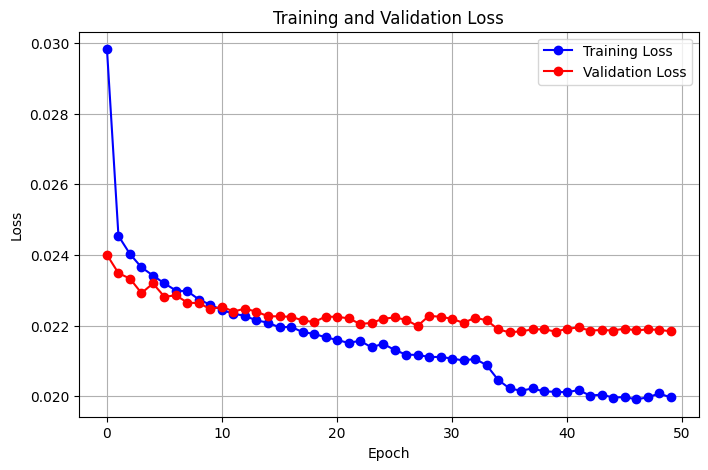

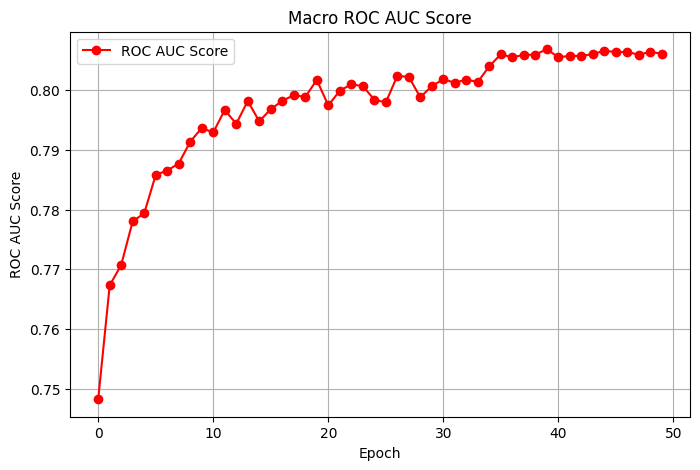

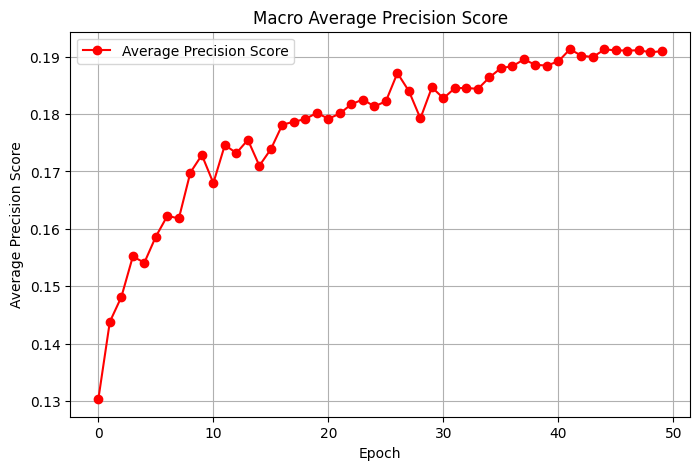


--- Starting Fold 5/5 ---
  --> Epoch 1: Best AUC Updated: 0.7530
Epoch 1 Train_loss: 0.0298 | Val_Loss: 0.0244 | Val_AUC: 0.7530| Val_avg_prec: 0.1285
  --> Epoch 2: Best AUC Updated: 0.7653
Epoch 2 Train_loss: 0.0244 | Val_Loss: 0.0238 | Val_AUC: 0.7653| Val_avg_prec: 0.1391
  --> Epoch 3: Best AUC Updated: 0.7713
Epoch 3 Train_loss: 0.0238 | Val_Loss: 0.0238 | Val_AUC: 0.7713| Val_avg_prec: 0.1461
  --> Epoch 4: Best AUC Updated: 0.7790
Epoch 4 Train_loss: 0.0235 | Val_Loss: 0.0235 | Val_AUC: 0.7790| Val_avg_prec: 0.1485
  --> Epoch 5: Best AUC Updated: 0.7803
Epoch 5 Train_loss: 0.0234 | Val_Loss: 0.0234 | Val_AUC: 0.7803| Val_avg_prec: 0.1569
  --> Epoch 6: Best AUC Updated: 0.7868
Epoch 6 Train_loss: 0.0231 | Val_Loss: 0.0230 | Val_AUC: 0.7868| Val_avg_prec: 0.1616
Epoch 7 Train_loss: 0.0231 | Val_Loss: 0.0231 | Val_AUC: 0.7864| Val_avg_prec: 0.1627
  --> Epoch 8: Best AUC Updated: 0.7882
Epoch 8 Train_loss: 0.0228 | Val_Loss: 0.0231 | Val_AUC: 0.7882| Val_avg_prec: 0.1667
  -->

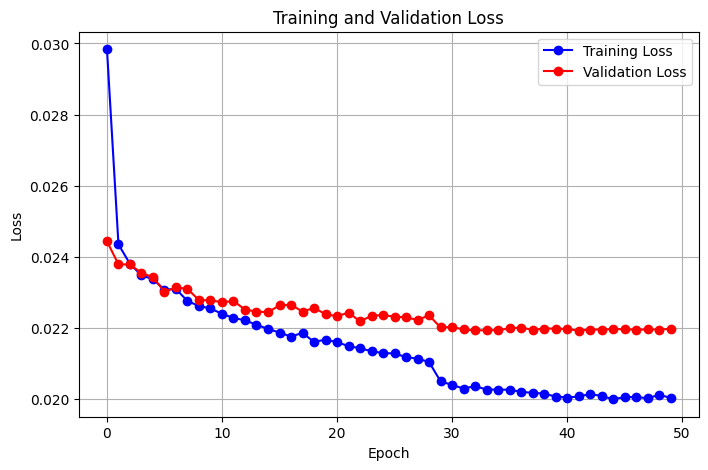

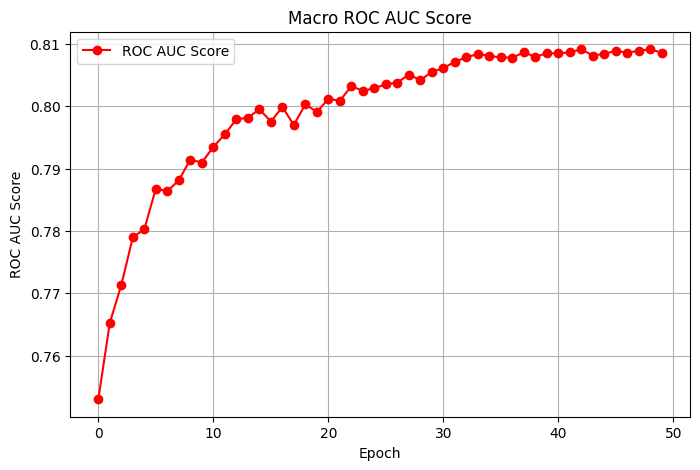

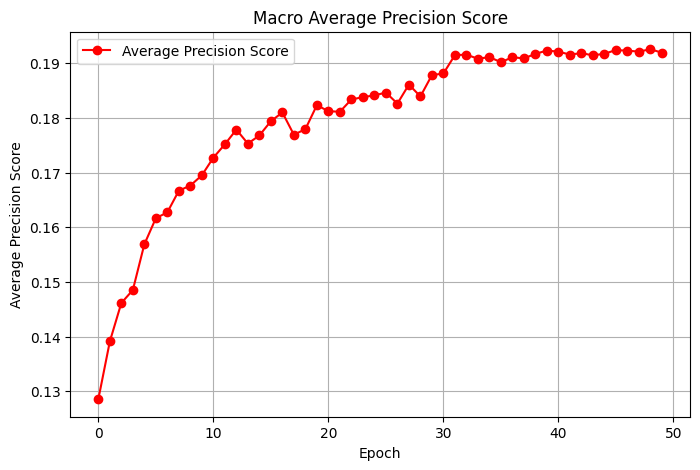

Cross-Validation complete.


In [18]:
import numpy as np
from torch.utils.data import DataLoader, Subset
from skmultilearn.model_selection import IterativeStratification

device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the K-Fold splitter
k_folds = 5
stratifier = IterativeStratification(n_splits=k_folds, order=1)

# Initialize indices
indices = np.arange(len(env_train))

# Store results for Out-of-fold (OOF) analysis
oof_probs = np.zeros(species_train.shape)

for fold, (train_idx, val_idx) in enumerate(stratifier.split(env_train, species_train)):
    print(f"\n--- Starting Fold {fold+1}/{k_folds} ---")

    # Initial DataLoader setup using split=None
    full_train_data = GeoPlantDataset(tabular=env_train, labels=species_train, split=None)
    train_loader = DataLoader(Subset(full_train_data, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(full_train_data, val_idx), batch_size=32, shuffle=False)

    # 3. Initialize fresh model for every fold
    model = TabularEncoder().to(device)
    criterion = MultiLabelFocalLoss(gamma=2.0, alpha=species_weights)
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

    EPOCHS = 50
    best_auc = 0
    best_model_state = None

    train_loss_list = []
    val_loss_list = []
    macro_auc_list = []
    macro_avg_prec_list = []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device=device)
        val_auc, val_avg_prec, val_loss = evaluate(model, val_loader, criterion, device=device)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        macro_auc_list.append(val_auc)
        macro_avg_prec_list.append(val_avg_prec)

        scheduler.step(val_loss)

        if  val_auc > best_auc:
            best_auc = val_auc
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f"  --> Epoch {epoch+1}: Best AUC Updated: {val_auc:.4f}")

        print(f"Epoch {epoch+1} Train_loss: {train_loss:.4f} | Val_Loss: {val_loss:.4f} | Val_AUC: {val_auc:.4f}| Val_avg_prec: {val_avg_prec:.4f}")

    # OOF Predictions
    print(f"Generating OOF predictions for Fold {fold+1}...")
    model.load_state_dict(best_model_state)
    model.eval()

    fold_preds = []
    with torch.no_grad():
        for img, _ in val_loader:
            logits = model(img.to(device))
            probs = torch.sigmoid(logits)
            fold_preds.append(probs.cpu().numpy())

    # Store predictions in the indices corresponding to this validation fold
    oof_probs[val_idx] = np.concatenate(fold_preds, axis=0)

    model_path = f"Models/Climate_data/Best_model_fold_{fold}.pth"
    torch.save(best_model_state, model_path)
    print(f"Saved best model for Fold {fold} to {model_path}")

    plt.figure(figsize=(8,5))
    plt.plot(train_loss_list, label='Training Loss', color='blue', marker='o')
    plt.plot(val_loss_list, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    image_path = f"Models/Climate_data/Fold_{fold}_loss.png"
    plt.savefig(image_path, dpi=300)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(macro_auc_list, label='ROC AUC Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC Score')
    plt.title('Macro ROC AUC Score')
    plt.legend()
    plt.grid(True)
    image_path_ROC_AUC = f"Models/Climate_data/Fold_{fold}_ROC_AUC.png"
    plt.savefig(image_path_ROC_AUC, dpi=300)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(macro_avg_prec_list, label='Average Precision Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Precision Score')
    plt.title('Macro Average Precision Score')
    plt.legend()
    plt.grid(True)
    Image_path_avg_prec = f"Models/Climate_data/Fold_{fold}_avg_prec.png"
    plt.savefig(Image_path_avg_prec, dpi=300)
    plt.show()


print("Cross-Validation complete.")

## 5. Test the model

In [19]:
def ensemble_predictions(model, loader, weight_paths, device="cuda"):
    """
    1. Loads each fold model.
    2. Generates probabilities for the test set.
    3. Averages them (Ensembling).
    """
    model.to(device)
    all_fold_probs = []
    test_labels = []

    for fold_idx, path in enumerate(weight_paths):
        print(f"--> Processing Fold {fold_idx} weights...")

        # Load the saved state dict
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
        model.eval()

        fold_probs = []
        with torch.no_grad():
            for img, y in loader:
                img = img.to(device).float()

                # Get logits and convert to probabilities
                logits = model(img)
                probs = torch.sigmoid(logits)

                fold_probs.append(probs.cpu().numpy())

                # Only collect labels once
                if fold_idx == 0:
                    test_labels.append(y.numpy())

        # Combine batches for this specific fold
        all_fold_probs.append(np.concatenate(fold_probs, axis=0))

    # Average probabilities across all folds
    ensemble_probs = np.mean(all_fold_probs, axis=0)

    # Final labels for metric calculation
    labels = np.concatenate(test_labels, axis=0)

    return ensemble_probs, labels

In [20]:
# List saved model files
fold_weight_files = [f"Models/Climate_data/Best_model_fold_{i}.pth" for i in range(5)]

# Generate the ensemble probabilities
ensemble_probs, test_labels = ensemble_predictions(
    model=TabularEncoder(),
    loader=test_loader,
    weight_paths=fold_weight_files,
    device=device
)

--> Processing Fold 0 weights...
--> Processing Fold 1 weights...
--> Processing Fold 2 weights...
--> Processing Fold 3 weights...
--> Processing Fold 4 weights...


## 6. Evaluate the model

### 6.1 Finding best threshold using OOF analysis

In [21]:
def find_optimal_thresholds(y_true, oof_probs):
    """
    Finds the best threshold for each of the 342 species.
    y_true: Ground truth labels (N, 342)
    oof_probs: Out-of-fold predictions (N, 342)
    """
    num_species = y_true.shape[1]
    best_thresholds = np.zeros(num_species)

    # Range of thresholds to test
    thresholds = np.linspace(0, 1, 100)

    print("Optimizing thresholds for 342 species...")

    for i in range(num_species):
        species_labels = y_true[:, i]
        species_probs = oof_probs[:, i]

        # Default to 0.5
        if species_labels.sum() == 0:
            best_thresholds[i] = 0.5
            continue

        best_fbeta = -1
        best_thresh = 0.5

        for t in thresholds:
            preds = (species_probs >= t).astype(int)
            score = fbeta_score(species_labels, preds, beta=0.5, zero_division=0) # Use fbeta to raise precision

            if score > best_fbeta:
                best_fbeta = score
                best_thresh = t

        best_thresholds[i] = best_thresh

    print("Optimization complete.")
    return best_thresholds

In [22]:
opt_thresholds = find_optimal_thresholds(species_train, oof_probs)
binary_preds = (ensemble_probs >= opt_thresholds).astype(int)

Optimizing thresholds for 342 species...
Optimization complete.


### 6.2 Fully evaluating the ensemble model

In [23]:
def full_evaluation(preds, labels, opt_thresholds, binary_preds):
    macro_auc = roc_auc_score(labels, preds, average='macro')
    micro_auc = roc_auc_score(labels, preds, average='micro')

    macro_avg_prec = average_precision_score(labels, preds, average='macro')
    micro_avg_prec = average_precision_score(labels, preds, average='micro')

    macro_f1 = f1_score(labels, binary_preds, average='macro')
    micro_f1 = f1_score(labels, binary_preds, average='micro')

    macro_precision = precision_score(labels, binary_preds, average='macro', zero_division=0)
    micro_precision = precision_score(labels, binary_preds, average='micro', zero_division=0)

    macro_recall = recall_score(labels, binary_preds, average='macro')
    micro_recall = recall_score(labels, binary_preds, average='micro')

    subset_acc = (binary_preds == labels).all(axis=1).mean()

    rank_loss = label_ranking_loss(labels, preds)

    return {
        "Macro ROC AUC": macro_auc,
        "Micro ROC AUC": micro_auc,
        "Macro Average Precision": macro_avg_prec,
        "Micro Average Precision": micro_avg_prec,
        "Macro Recall": macro_recall,
        "Micro Recall": micro_recall,
        "Macro F1": macro_f1,
        "Micro F1": micro_f1,
        "Macro Precision": macro_precision,
        "Micro Precision": macro_precision,
        "Subset Accuracy": subset_acc,
        "Ranking Loss": rank_loss
    }


In [24]:
results = full_evaluation(ensemble_probs, test_labels, opt_thresholds, binary_preds)
print("Metrics for focal model:")
for k,v in results.items():
    print(k, ":", v)

Metrics for focal model:
Macro ROC AUC : 0.818211846556913
Micro ROC AUC : 0.8300694384339586
Macro Average Precision : 0.2005770333962439
Micro Average Precision : 0.16405793683927392
Macro Recall : 0.22399992648415937
Micro Recall : 0.2772522871763064
Macro F1 : 0.19584528244388874
Micro F1 : 0.24258869818872533
Macro Precision : 0.2550774723370236
Micro Precision : 0.2550774723370236
Subset Accuracy : 0.006
Ranking Loss : 0.17137644915406883


# 7. Retraining model on full training dataset using hyperparameters

In [25]:
full_train_data = GeoPlantDataset(tabular=env_train, labels=species_train, split=None)
full_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)

# Initialize fresh model
final_model = TabularEncoder().to(device)
criterion = MultiLabelFocalLoss(gamma=2.0, alpha=species_weights)
optimizer = torch.optim.AdamW(final_model.parameters())

final_epochs = 45

print(f"Starting final retraining on 100% of data for {final_epochs} epochs...")

final_model.train()
for epoch in range(final_epochs):
    train_loss = train_epoch(final_model, full_loader, optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}/{final_epochs} | Loss: {train_loss:.4f}")

torch.save(final_model.state_dict(), "Models/Climate_data/Climate_data_model.pth")

Starting final retraining on 100% of data for 45 epochs...
Epoch 1/45 | Loss: 0.0291
Epoch 2/45 | Loss: 0.0243
Epoch 3/45 | Loss: 0.0239
Epoch 4/45 | Loss: 0.0235
Epoch 5/45 | Loss: 0.0231
Epoch 6/45 | Loss: 0.0230
Epoch 7/45 | Loss: 0.0228
Epoch 8/45 | Loss: 0.0227
Epoch 9/45 | Loss: 0.0225
Epoch 10/45 | Loss: 0.0225
Epoch 11/45 | Loss: 0.0223
Epoch 12/45 | Loss: 0.0223
Epoch 13/45 | Loss: 0.0222
Epoch 14/45 | Loss: 0.0220
Epoch 15/45 | Loss: 0.0220
Epoch 16/45 | Loss: 0.0219
Epoch 17/45 | Loss: 0.0218
Epoch 18/45 | Loss: 0.0218
Epoch 19/45 | Loss: 0.0218
Epoch 20/45 | Loss: 0.0216
Epoch 21/45 | Loss: 0.0217
Epoch 22/45 | Loss: 0.0215
Epoch 23/45 | Loss: 0.0216
Epoch 24/45 | Loss: 0.0215
Epoch 25/45 | Loss: 0.0214
Epoch 26/45 | Loss: 0.0213
Epoch 27/45 | Loss: 0.0213
Epoch 28/45 | Loss: 0.0211
Epoch 29/45 | Loss: 0.0212
Epoch 30/45 | Loss: 0.0212
Epoch 31/45 | Loss: 0.0211
Epoch 32/45 | Loss: 0.0211
Epoch 33/45 | Loss: 0.0211
Epoch 34/45 | Loss: 0.0211
Epoch 35/45 | Loss: 0.0209
Epoch

In [26]:
def test_merged_model(model, loader, device="cuda"):
    model.eval()
    merged_probs = []
    labels = []

    with torch.no_grad():
        for env, y in loader:

            env = env.to(device).float()

            logits = model(env)
            probs = torch.sigmoid(logits)

            merged_probs.append(probs.cpu())
            labels.append(y)

    merged_probs = torch.cat(merged_probs).numpy()
    labels = torch.cat(labels).numpy()

    return merged_probs, labels

In [27]:
merged_model_probs, test_labels = test_merged_model(model=final_model, loader=test_loader, device=device)

In [28]:
merged_model_binary_preds = (merged_model_probs >= opt_thresholds).astype(int)

In [29]:
results = full_evaluation(merged_model_probs, test_labels, opt_thresholds, merged_model_binary_preds)
print("Metrics for focal model:")
for k,v in results.items():
    print(k, ":", v)

Metrics for focal model:
Macro ROC AUC : 0.8159653236686936
Micro ROC AUC : 0.8223513059472242
Macro Average Precision : 0.19681871332639672
Micro Average Precision : 0.1549473440864564
Macro Recall : 0.22057447726645998
Micro Recall : 0.25942006512637616
Macro F1 : 0.1849970783204953
Micro F1 : 0.224
Macro Precision : 0.23807739682321927
Micro Precision : 0.23807739682321927
Subset Accuracy : 0.007
Ranking Loss : 0.17895205209702789


In [30]:
# Calculate F1 per species
from sklearn.metrics import f1_score
per_species_f1 = f1_score(test_labels, merged_model_binary_preds, average=None, zero_division=0)

# Sort them
sorted_indices = np.argsort(per_species_f1)[::-1]

print("Top 5 Species F1:", per_species_f1[sorted_indices[:5]])
print("Bottom 5 Species F1:", per_species_f1[sorted_indices[-5:]])
print("Number of species with 0.0 F1:", np.sum(per_species_f1 == 0))

Top 5 Species F1: [0.78787879 0.63694268 0.62337662 0.61538462 0.58823529]
Bottom 5 Species F1: [0. 0. 0. 0. 0.]
Number of species with 0.0 F1: 43


### Multilabel confusion matrix

In [31]:
from sklearn.metrics import multilabel_confusion_matrix

matrices = multilabel_confusion_matrix(test_labels, merged_model_binary_preds)

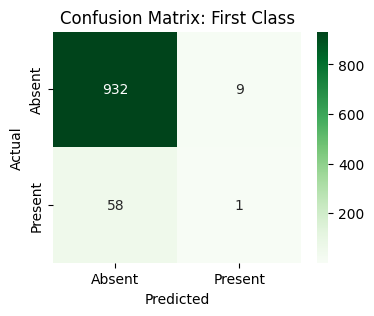

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


first_class_matrix = matrices[100]
first_class_name = "First Class"

# 3. Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(first_class_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Absent', 'Present'],
            yticklabels=['Absent', 'Present'])

plt.title(f"Confusion Matrix: {first_class_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 7. Visualization on map

In [36]:
import folium
def map_predictions_species(preds, labels, species_index, test_lats, test_lons, show_types=None):
    """
    Creates a Folium map showing prediction correctness for a specific species.

    Parameters:
    - all_preds: np.array of shape (num_samples, num_species), model predictions (0/1)
    - all_labels: np.array of shape (num_samples, num_species), true labels (0/1)
    - species_index: int, index of the species to visualize
    - test_lats: list or array of latitude values
    - test_lons: list or array of longitude values
    - show_types: set of strings indicating which prediction types to show.
                  Options: 'TP', 'TN', 'FP', 'FN'
                  Default: None (show all)
    """

    print("Number of species prediction:")
    print(preds[:,species_index].sum())
    print("Number of species occurence:")
    print(labels[:,species_index].sum())

    if show_types is None:
        show_types = {'TP', 'TN', 'FP', 'FN'}  # show all by default

    center_lat = np.mean(test_lats)
    center_lon = np.mean(test_lons)
    fmap = folium.Map(location=[center_lat, center_lon], zoom_start=4)

    preds_species = preds[:, species_index]
    labels_species = labels[:, species_index]

    for lat, lon, pred, label in zip(test_lats, test_lons, preds_species, labels_species):
        # Determine prediction type and color
        if pred == 1 and label == 1:
            pred_type = 'TP'
            color = 'green'
        elif pred == 0 and label == 1:
            pred_type = 'FN'
            color = 'red'
        elif pred == 0 and label == 0:
            pred_type = 'TN'
            color = 'blue'
        else:  # pred == 1 and label == 0
            pred_type = 'FP'
            color = 'orange'

        if pred_type not in show_types:
            continue  # skip this point if not in selected types

        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6
        ).add_to(fmap)

    return fmap

In [37]:
map_predictions_species(preds=binary_preds, labels=test_labels, species_index=30, test_lats=test_lats, test_lons=test_lons)

Number of species prediction:
46
Number of species occurence:
46.0
